In [13]:
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm.autonotebook import tqdm
from matplotlib.colors import Normalize
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K
from keras.models import Sequential
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import load_model
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

BY: 
* 19bce128 : mihir prajapati
* 19bce139 : mitul nakrani
* 19bce163 : dhruva patel
* 19bce169 : esha patel
* 19bce292 : mithil vasava

In [14]:
train_df = pd.read_csv("../input/happy-whale-and-dolphin/train.csv")
train_df.head()
train_df_small = train_df[:50]
#print(train_df_small.image)

In [15]:
print("Total species before finding duplicates :",len(train_df.species.unique()))
train_df.species = train_df.species.str.replace('kiler_whale','killer_whale')
train_df.species = train_df.species.str.replace('bottlenose_dolpin','bottlenose_dolphin')
train_df['species'][(train_df['species'] =="pilot_whale") | (train_df['species'] =="globis" )]='short_finned_pilot_whale'
print("Total species after :",len(train_df.species.unique()))

Total species before finding duplicates : 30
Total species after : 26


In [16]:
animal_cnt = train_df.species.value_counts()
print("Occurences of different species:")
print(animal_cnt)
print(f"Total number of species: {len(animal_cnt)}")

Occurences of different species:
bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64
Total number of species: 26


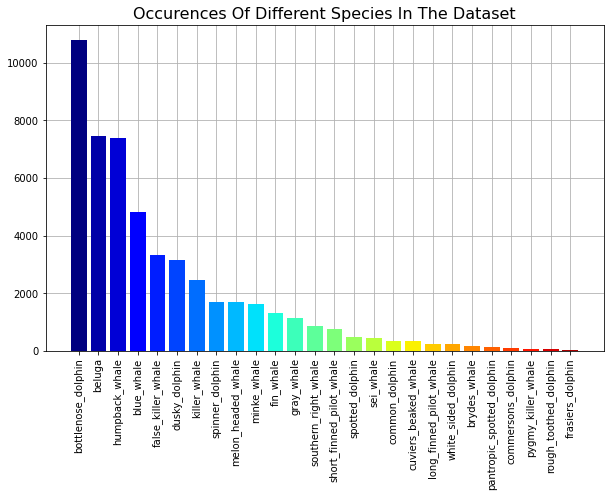

In [17]:
specs = list(animal_cnt.keys())
values = list(animal_cnt.values)

cmap = cm.get_cmap('jet')
norm = Normalize(vmin=0,vmax=len(specs))
cols = np.arange(0,len(specs))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
plt.grid(visible=True)
plt.bar(specs, values, color=cmap(norm(cols)))
plt.xticks(rotation='vertical')
plt.title('Occurences Of Different Species In The Dataset', fontsize=16, fontname="Times New Roman Bold")
plt.show()

In [18]:
print(train_df.shape)
print(train_df_small.shape)

(51033, 3)
(50, 3)


In [19]:
train_jpg_path = "../input/happy-whale-and-dolphin/train_images"
test_jpg_peth = "../input/happy-whale-and-dolphin/test_images"
train_images_list = os.listdir('../input/happy-whale-and-dolphin/train_images')
#train_images_list

In [20]:
def Loading_Images(data, m, dataset):
    print("Loading images")
    X_train = np.zeros((m, 32, 32, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("../input/happy-whale-and-dolphin/"+dataset+"/"+fig, target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

In [21]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [22]:
X = Loading_Images(train_df, train_df.shape[0], "train_images")
X /= 255

Loading images


  0%|          | 0/51033 [00:00<?, ?it/s]

In [23]:
y, label_encoder = prepare_labels(train_df['individual_id'])

In [24]:
print(X.shape)
print(y.shape)
gc.collect()

(51033, 32, 32, 3)
(51033, 15587)


64

In [25]:
y.shape

(51033, 15587)

In [26]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

base_model = EfficientNetB0(input_shape=(32,32,3), weights=None, include_top=False)

layer = base_model.output
#layer = GlobalAveragePooling2D()(layer)#extra
#layer = Dropout(0.5)(layer)#extra
layer = Dense(1024, activation='relu')(layer)
#layer = Dense(512, activation='relu')(layer)#extra
layer = Flatten()(layer)
predictions = Dense(y.shape[1], activation='softmax')(layer)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
#model.summary()

In [27]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.20,
                                   )

#train_datagen.fit(X)

In [28]:
#history = model.fit(train_datagen.flow(X,y,batch_size=128,subset='training'),validation_data=train_datagen.flow(X,y,batch_size=128,subset='validation'),epochs=180)
history = model.fit(X, y, epochs = 200, batch_size=128, verbose=1)

2022-04-21 16:03:45.826329: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3181805484 exceeds 10% of free system memory.
2022-04-21 16:03:49.970931: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3181805484 exceeds 10% of free system memory.
2022-04-21 16:03:52.572390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-04-21 16:04:00.943084: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


511/511 [==============================] - 42s 54ms/step - loss: 8.7140 - accuracy: 0.0085
Epoch 2/200
511/511 [==============================] - 27s 53ms/step - loss: 8.0425 - accuracy: 0.0112
Epoch 3/200
511/511 [==============================] - 27s 52ms/step - loss: 7.8127 - accuracy: 0.0118
Epoch 4/200
511/511 [==============================] - 26s 52ms/step - loss: 7.5898 - accuracy: 0.0129
Epoch 5/200
511/511 [==============================] - 27s 52ms/step - loss: 7.3301 - accuracy: 0.0152
Epoch 6/200
511/511 [==============================] - 27s 52ms/step - loss: 7.1675 - accuracy: 0.0160
Epoch 7/200
511/511 [==============================] - 27s 53ms/step - loss: 6.9936 - accuracy: 0.0171
Epoch 8/200
511/511 [==============================] - 27s 52ms/step - loss: 6.8395 - accuracy: 0.0184
Epoch 9/200
511/511 [==============================] - 27s 54ms/step - loss: 6.6961 - accuracy: 0.0192
Epoch 10/200
511/511 [==============================] - 26s 51ms/step - loss: 6.5556 

In [29]:
model.save('./effb0_0.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (6, 6), strides = (1, 1), input_shape = (32, 32, 3)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
      
    model.add(Conv2D(64, (3, 3), strides = (1,1)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3)))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.85))

    model.add(Dense(y.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return(model)

In [31]:
Cnn_model = cnn_model()

In [32]:
del X
del y
gc.collect()

1389

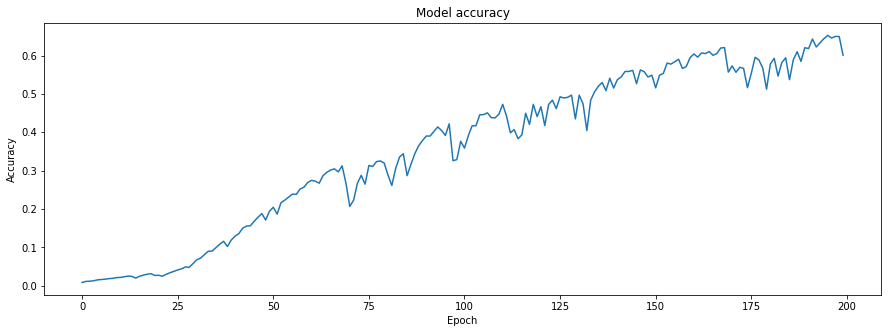

In [33]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

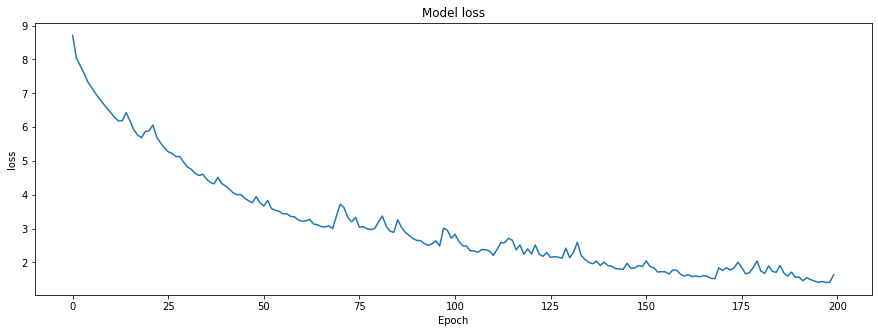

In [34]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [35]:
test = os.listdir("../input/happy-whale-and-dolphin/test_images")
print(len(test))

27956


In [36]:
col = ['image']
test_df = pd.DataFrame(test, columns=col)
test_df['predictions'] = ''

In [38]:
#model = load_model(r'../input/happywhaleanddolphin1/effb0_0.h5')

In [39]:
batch_size=5000
batch_start = 0
batch_end = batch_size
L = len(test_df)

while batch_start < L:
    limit = min(batch_end, L)
    test_df_batch = test_df.iloc[batch_start:limit]
    print(type(test_df_batch))
    X = Loading_Images(test_df_batch, test_df_batch.shape[0], "test_images")
    X /= 255
    predictions = model.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p=pred.argsort()[-5:][::-1]
        idx=-1
        s=''
        s1=''
        s2=''
        for x in p:
            idx=idx+1
            if pred[x]>0.5:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s= s1 + ' new_individual' + s2
        s = s.strip(' ')
        test_df.loc[ batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    del X
    del test_df_batch
    del predictions
    gc.collect()

<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 3s 12ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 12ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 11ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 11ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 12ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/2956 [00:00<?, ?it/s]

93/93 [==============================] - 1s 13ms/step


In [40]:
test_df.to_csv('submission.csv',index=False)
test_df.head()

,image,predictions
0,cd50701ae53ed8.jpg,17033c413878 new_individual 84d91f8c1f99 2e3be...
1,177269f927ed34.jpg,769ff7fba769 new_individual 4c5307459d85 c9d65...
2,9137934396d804.jpg,0a948f6b1de4 new_individual a6e325d8e924 361bd...
3,c28365a55a0dfe.jpg,new_individual dd8c756c9cb7 1492507238d8 bc1eb...
4,1a40b7b382923a.jpg,new_individual 6f632b846891 2e0b381d3467 fbc05...


In [42]:
test_df.to_csv('submission_whale_and_dolphin.csv', index = False)